In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Exploratory Data Analysis

In [2]:
# Data reading and processing
import re
import pandas as pd
import numpy as np
import warnings
from scipy.stats import randint as sp_randint
from datetime import datetime

import os
from os import path

# Visualisation
from matplotlib import pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting current directory as same directory where code is stored
try:
    CUR_DIR = dirname(realpath(__file__))
except NameError:
    CUR_DIR = os.getcwd()

In [4]:
# Additional functions
## Creating charts
def create_stacked_bar(matrix, axis):
    bar_renderers = []
    ind = np.arange(matrix.shape[1])
    bottoms = np.cumsum(np.vstack((np.zeros(matrix.shape[1]), matrix)), axis=0)[:-1]
    for i, row in enumerate(matrix):
        r = axis.bar(ind, row, width=0.5, bottom=bottoms[i])
        bar_renderers.append(r)
    return bar_renderers

def create_clustered_bar(matrix, axis):
    bar_renderers = []
    x = np.arange(matrix.shape[0])
    dx = (np.arange(matrix.shape[1])-matrix.shape[1]/2.)/(matrix.shape[1]+2.)
    d = 1./(matrix.shape[1]+2.)

    for i in range(matrix.shape[1]):
        r = axis.bar(x+dx[i],matrix[:,i], width=d)
        bar_renderers.append(r)
    return bar_renderers

def format_subplot(axis, title, x_label, x_ticks=None):
    axis.set_title(title,fontsize=20)
    axis.set_xlabel(x_label)
    if x_ticks is not None:
        axis.set_xticks(x_ticks)
    return

## Print confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.i".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

## Reading in data and brief stats

In [25]:
# Import data files
train = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'trainingData.csv'),index_col=None)
test = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'validationData.csv'),index_col=None)

print('Training dataset (length, width) = %s' % str(train.shape))
print('Validation dataset (length, width) = %s' % str(test.shape))

# Import mapping files
map_user = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'userMap.csv'),index_col=None)
map_phone = pd.DataFrame.from_csv(path.join(CUR_DIR, "input", 'phoneMap.csv'),index_col=None)

Training dataset (length, width) = (19937, 529)
Validation dataset (length, width) = (1111, 529)


### Viewing data sample (non-WAP columns) and statistical summary

In [7]:
train[[x for x in train.columns if 'WAP' not in x]].head()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [8]:
train[[x for x in train.columns if 'WAP' not in x]].describe()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


## EDA on *Target Variables*
* Understand distribution of data better
* Validate that the target variables are varied enough to get a robust output from modelling
* If necessary, filtering of records

### Distribution of records by user

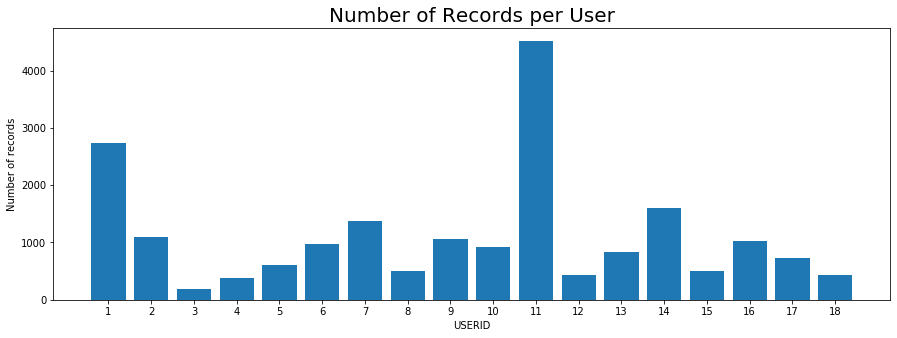

In [9]:
user_counts = train.groupby(['USERID']).TIMESTAMP.count().reset_index()
plt.figure(figsize=(15,5))
plt.bar(user_counts['USERID'],height=user_counts['TIMESTAMP'])
plt.xticks(user_counts['USERID'])
plt.title('Number of Records per User',fontsize=20)
plt.xlabel('USERID')
plt.ylabel('Number of records')
plt.show()

User 11 has the highest amount of activity recorded, more than 25% than the 2nd most active user (User 1).

### Number of records by longitude and latitude

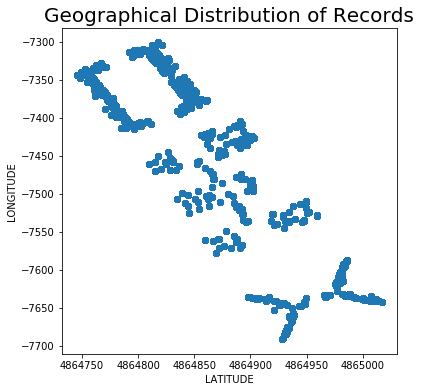

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(train['LATITUDE'],train['LONGITUDE'])
plt.title("Geographical Distribution of Records",fontsize=20)
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.show()

External shape of buildings can be seen from plotting longitude and latitude.

### Number of records by building & floor

In [11]:
fb_counts = train.groupby(['FLOOR','BUILDINGID']).TIMESTAMP.count().reset_index()
# Inserting dummy rows for missing floor x building combinations
for f in np.arange(0,5):
    for b in np.arange(0,3):
        if not ((fb_counts['FLOOR'] == f) & (fb_counts['BUILDINGID'] == b)).any():
            fb_counts = fb_counts.append({'FLOOR':f,'BUILDINGID':b,'TIMESTAMP':0}, ignore_index=True)
fb_counts.groupby(['BUILDINGID']).TIMESTAMP.sum().reset_index().rename(columns={'TIMESTAMP':'RECORDS'})

,BUILDINGID,RECORDS
0,0,5249
1,1,5196
2,2,9492


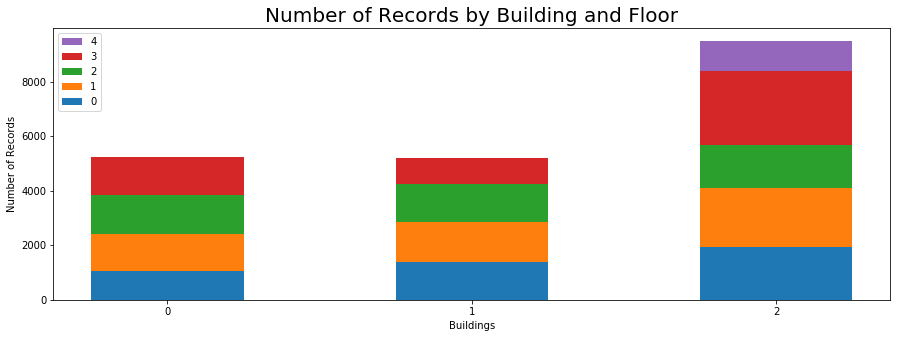

In [12]:
pivot_fb = fb_counts.pivot(index='FLOOR',columns='BUILDINGID')
buildings = list(set(fb_counts['BUILDINGID'].tolist()))

plt.figure(figsize=(15,5))

bars = create_stacked_bar(pivot_fb.values, plt)
# Plot formatting
plt.legend((reversed([x[0] for x in bars])), (4,3,2,1,0),fancybox=True)
plt.title('Number of Records by Building and Floor', fontsize=20)
plt.xticks(buildings)
plt.xlabel('Buildings')
plt.ylabel('Number of Records')

plt.show()

In [13]:
pivot_fb.columns = pivot_fb.columns.droplevel()
pivot_fb = pivot_fb.sort_index(ascending=False)
for col in pivot_fb.columns:
    total = pivot_fb[col].sum()
    pivot_fb[col] = pivot_fb[col].apply(lambda x: "%.2f%%" % ((x/total)*100))
pivot_fb

BUILDINGID,0,1,2
FLOOR,,,
4,0.00%,0.00%,11.61%
3,26.50%,18.24%,28.54%
2,27.49%,26.87%,16.61%
1,25.83%,28.56%,22.78%
0,20.18%,26.33%,20.46%


* Only Building 2 has Level 4
* Relatively even distribution across all floors in Buildings 0 and 1
* Higher activity levels recorded on Levels 1 & 3 for Building 2

## EDA on *Input Variables*
#### In addition to examining the target variables, a quick sense check is conducted on the input variables as well. 
* Due to high dimensionality (520 WAP columns), the variables are condensed to a single column per record - highest signal strength across all WAP
* Adds additional layer of analysis based on factors not considered by mere count of records - e.g. how does height of user / phone used / building floor affect signal strength
* Might help explain any variance in prediction models - e.g. higher accuracy for certain buildings & floors

#### Maximum RSSI of the WAPs - check whether any WAPs have no recorded data; aids in feature selection for modelling

### Condensing input variables into single column - max_signal

In [14]:
sub_train = train[[x for x in train.columns if 'WAP' not in x]]
sub_train['max_signal'] = train.loc[:,[x for x in train.columns if 'WAP' in x]].replace(100,np.NaN).max(axis=1)
sub_train.head()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,max_signal
0,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,-53.0
1,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,-46.0
2,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,-61.0
3,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,-55.0
4,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,NaN


As seen in Row 4 of the sample table, some records do not have any *max_signal* strength - all WAPs for that record received no RSSI reading (denoted as 100 in this dataset). These rows are **not** automatically filtered out as they might provide additional insights and be essential to modelling.

### Examining records with no RSSI readings (NaN records)

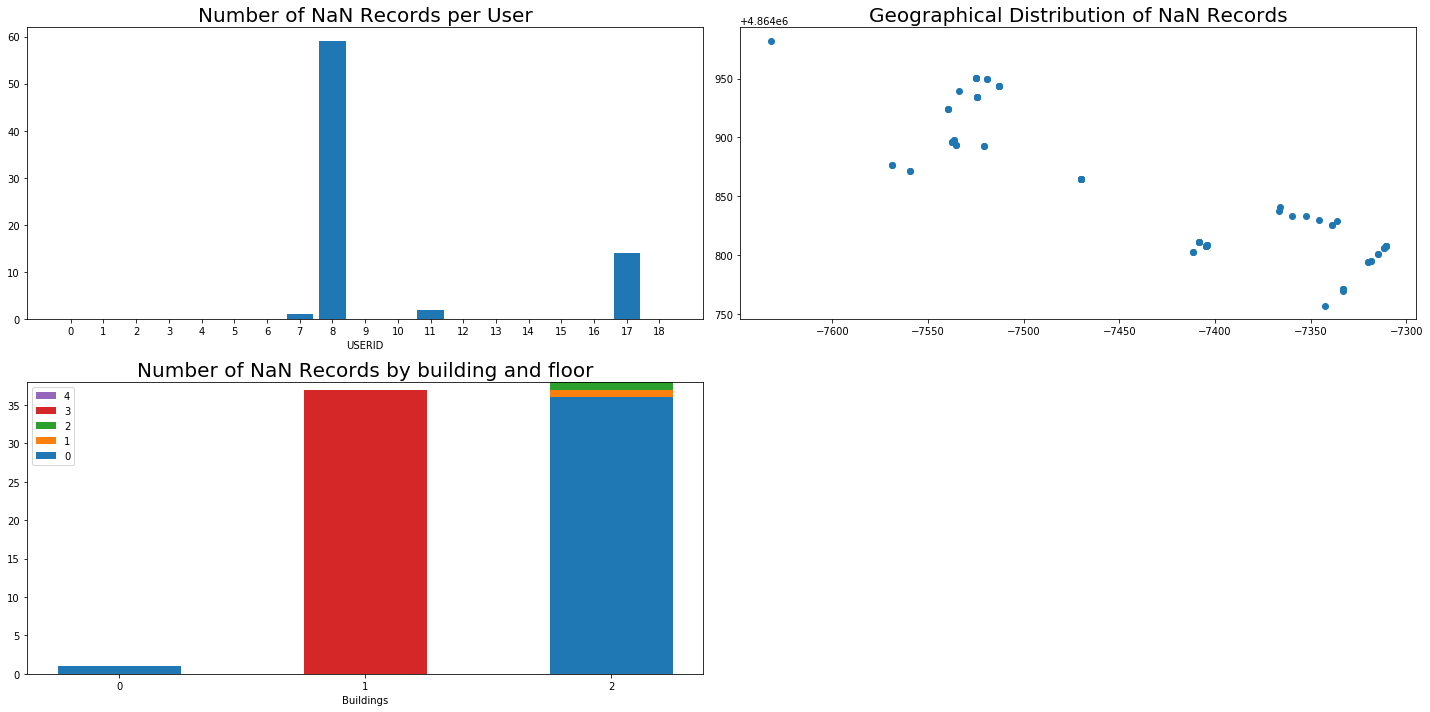

In [15]:
nan_sub = sub_train.loc[np.isnan(sub_train['max_signal']),]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,10))

# First subplot: distribution of NaN records per user
nan_users = nan_sub.groupby(['USERID']).TIMESTAMP.count().reset_index()
for x in np.arange(0,19):
    if x not in nan_users['USERID'].values:
        nan_users = nan_users.append({'USERID':x,'TIMESTAMP':0}, ignore_index=True)
ax1.bar(nan_users['USERID'],height=nan_users['TIMESTAMP'])
format_subplot(ax1, 'Number of NaN Records per User', 'USERID', nan_users['USERID'])

# Second subplot: lat-long scatter plot
ax2.scatter(nan_sub['LONGITUDE'],nan_sub['LATITUDE'])
ax2.set_title("Geographical Distribution of NaN Records",fontsize=20)

# Third subplot: building & floor
nan_fb = nan_sub.groupby(['FLOOR','BUILDINGID']).TIMESTAMP.count().reset_index()
for f in np.arange(0,5):
    for b in np.arange(0,3):
        if not ((nan_fb['FLOOR'] == f) & (nan_fb['BUILDINGID'] == b)).any():
            nan_fb = nan_fb.append({'FLOOR':f,'BUILDINGID':b,'TIMESTAMP':0}, ignore_index=True)
bars = create_stacked_bar(nan_fb.pivot(index='FLOOR',columns='BUILDINGID').values,ax3)
ax3.legend((reversed([x[0] for x in bars])), (4,3,2,1,0),fancybox=True)
format_subplot(ax3, 'Number of NaN Records by building and floor', 'Buildings', list(set(nan_fb['BUILDINGID'])))

ax4.axis('off')
plt.tight_layout()
plt.show()

In [16]:
nan_rows = sub_train['max_signal'].isnull().sum()
print("Number of records with no RSSI readings (i.e. NaN records): %i (%.2f%%)" % (nan_rows, (nan_rows/len(sub_train)*100)))

user8_nan = nan_users.loc[nan_users['USERID']==8,'TIMESTAMP'].sum()
print("Number of NaN records from User 8: %i (%.2f%%)" % (user8_nan, (user8_nan/nan_users['TIMESTAMP'].sum()*100)))

sub_test = test[[x for x in test.columns if 'WAP' not in x]]
sub_test['max_signal'] = test.loc[:,[x for x in test.columns if 'WAP' in x]].replace(100,np.NaN).max(axis=1)
test_nan = sub_test['max_signal'].isnull().sum()
print("Number of NaN records within VALIDATION set: %i (%.2f%%)" % (test_nan, (test_nan/len(sub_test)*100)))

Number of records with no RSSI readings (i.e. NaN records): 76 (0.38%)
Number of NaN records from User 8: 59 (77.63%)
Number of NaN records within VALIDATION set: 0 (0.00%)


Majority of the NaN records originate from User 8:
* Geographical distribution shows few concentrated clusters
* Large proportion of records from the same buildings & floors (Level 3 of Building 1 & Level 0 of Building 2)

It is safe enough to assume that this issue is largely limited to that particular user, probably with a regular schedule (concentrated location clusters).

Furthermore, these NaN records make up a very small percentage of training set (<1%) and there are no NaN records in the validation set.
#### These rows can be safely be filtered out.

In [17]:
nan_rows_index = nan_sub.index.tolist()
train = train.iloc[[x for x in train.index if x not in nan_rows_index]]
sub_train = sub_train.iloc[[x for x in train.index if x not in nan_rows_index]]

### Average max signal by user

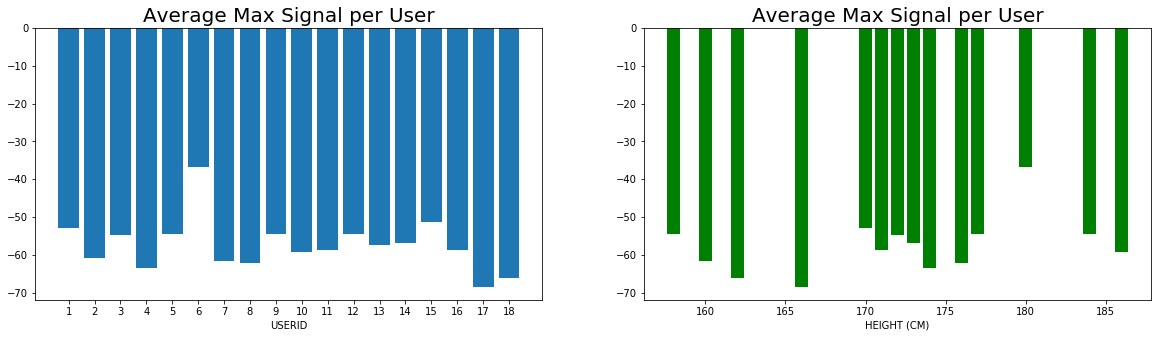

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
# First subplot: average max signal per user
signal_user = sub_train.groupby(['USERID']).max_signal.mean().reset_index()
ax1.bar(signal_user['USERID'],height=signal_user['max_signal'])
format_subplot(ax1, 'Average Max Signal per User', 'USERID', signal_user['USERID'])

# Second subplot: by device
signal_user = signal_user.merge(map_user,how='left',on='USERID')
ax2.bar(signal_user['HEIGHT'],height=signal_user['max_signal'],color='green')
format_subplot(ax2, 'Average Max Signal per User', 'HEIGHT (CM)')

plt.show()

In [19]:
print("Correlation between Average Max Signal and Height = %.4f" % signal_user['max_signal'].corr(signal_user['HEIGHT']))

Correlation between Average Max Signal and Height = 0.3501


* Variations in signal strength observed - User 6 has average strongest signal while User 17 has the weakest
* Height, while slightly positively correlated, does not seem to have a strong linear relationship with Average Max Signal

### Average max signal by phone model

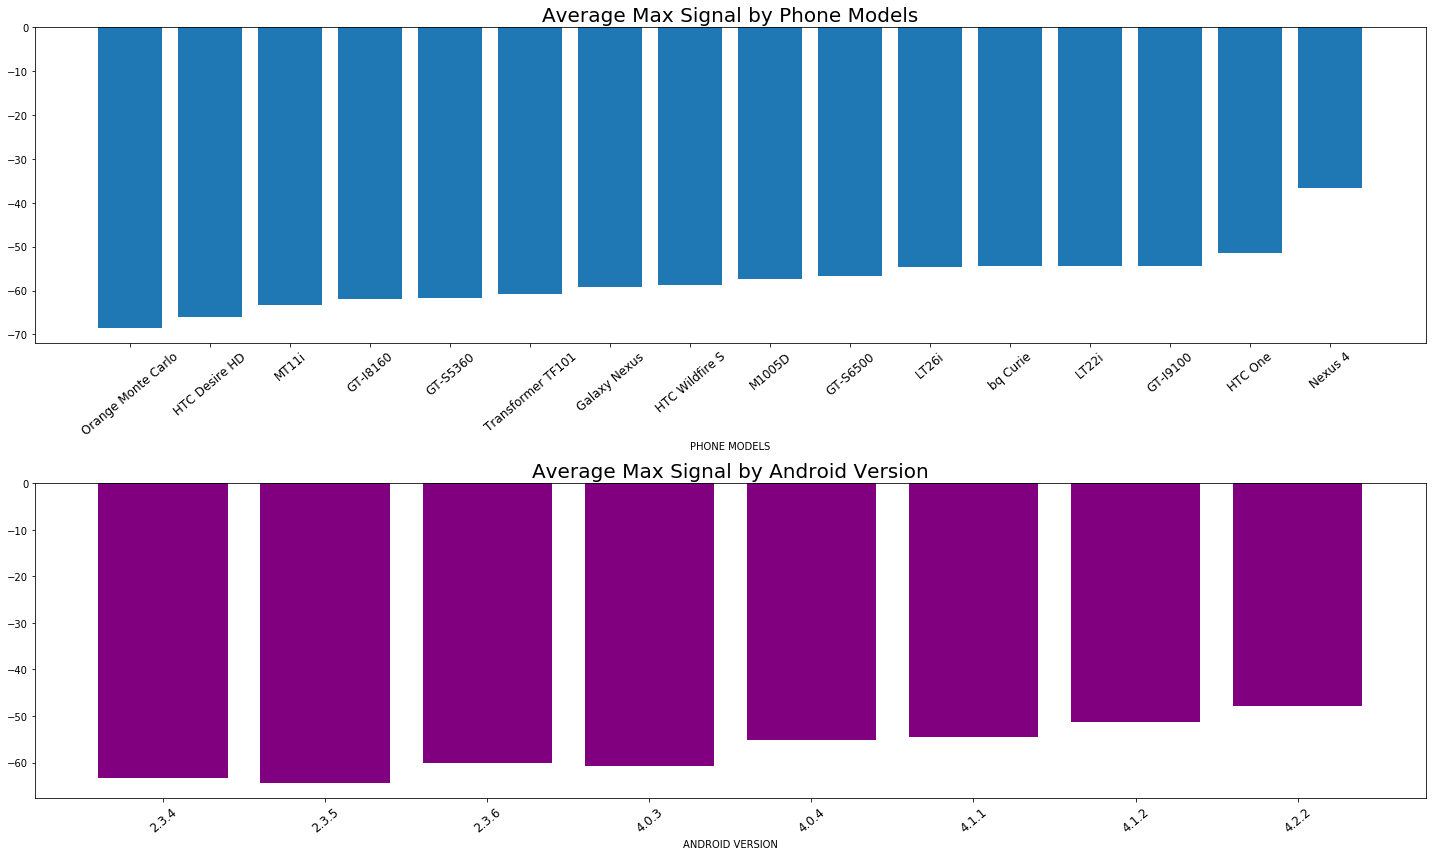

In [20]:
fig, ((ax1),(ax2)) = plt.subplots(2,1, figsize=(20,12))
signal_device = sub_train.groupby(['PHONEID']).max_signal.mean().reset_index()
signal_device = signal_device.merge(map_phone,how='left',on='PHONEID')

# First subplot: by device name
signal_device = signal_device.sort_values('max_signal').reset_index()
ax1.bar(signal_device.index, signal_device['max_signal'])
format_subplot(ax1, 'Average Max Signal by Phone Models', 'PHONE MODELS')
ax1.set_xticks(signal_device.index)
ax1.set_xticklabels(signal_device['DEVICE_NAME'],rotation=40,fontsize=12)

# Second subplot: by android version
signal_av = signal_device.groupby(['ANDROID_VER']).max_signal.mean().reset_index()
ax2.bar(signal_av.index, signal_av['max_signal'],color='purple')
format_subplot(ax2, 'Average Max Signal by Android Version', 'ANDROID VERSION')
ax2.set_xticks(signal_av.index)
ax2.set_xticklabels(signal_av['ANDROID_VER'],rotation=40,fontsize=12)

plt.tight_layout()
plt.show()

* Nexus 4 receives the strongest signal while Orange Monte Carlo receives the weakest
* Visible trend across Android versions - the newer the version, the stronger the signal received

### Average max signal by building & floor

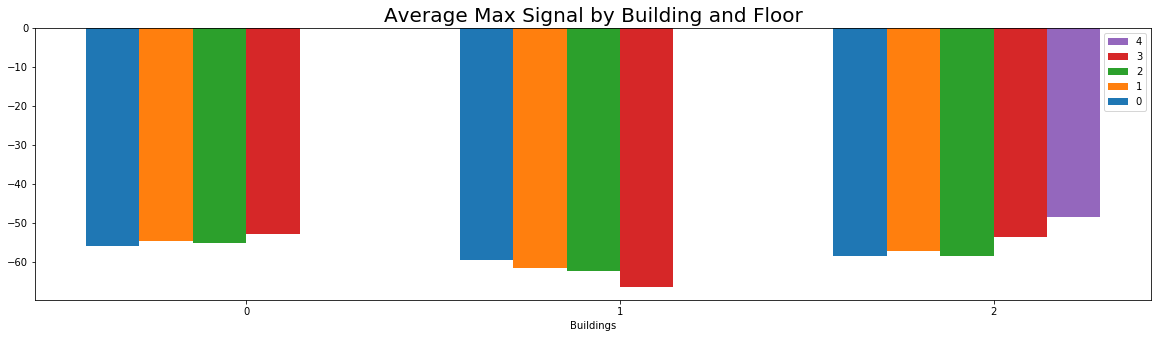

In [21]:
signal_fb = sub_train.groupby(['BUILDINGID','FLOOR']).max_signal.mean().reset_index().pivot(index='BUILDINGID',columns='FLOOR').fillna(0)
plt.figure(figsize=(20,5))
bars = create_clustered_bar(signal_fb.values,plt)
plt.legend((reversed([x[0] for x in bars])), (4,3,2,1,0),fancybox=True)
plt.title('Average Max Signal by Building and Floor',fontsize=20)
plt.xticks(signal_fb.index)
plt.xlabel('Buildings')
plt.show()

* Buildings 0 and 2 follow a similar trend - the higher the floor, the stronger the signal
* Whereas Building 1 reverses that trend
* Difficult to determine a causal relationship - could be affected by external factors (e.g. placement of WAPs, infrastructure of the buildings etc.)

### Sense check on RSSI across all WAPs

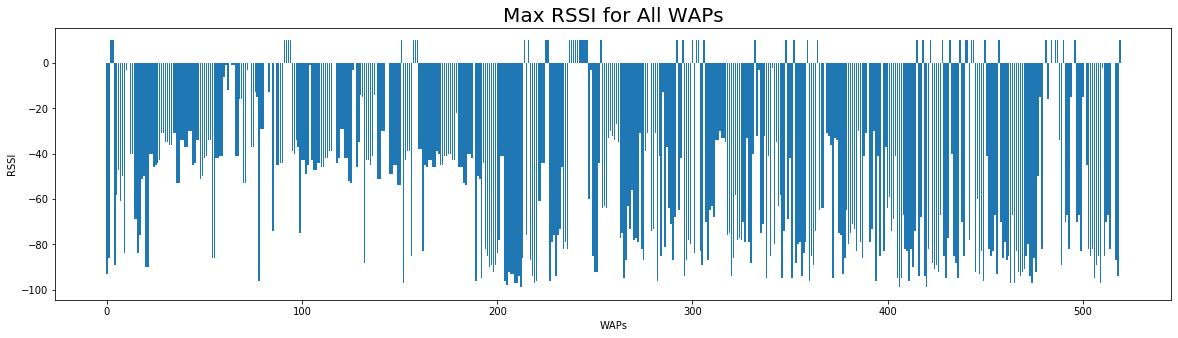

In [22]:
wap_max = train[[x for x in train.columns if 'WAP' in x]].replace(100,np.nan).max(axis=0).reset_index()
wap_max = wap_max.rename(columns={'index':'wap_name', 0: 'max_signal'}).fillna(10)
plt.figure(figsize=(20,5))
plt.bar(wap_max.index, wap_max['max_signal'])
plt.title('Max RSSI for All WAPs',fontsize=20)
plt.xlabel('WAPs')
plt.ylabel('RSSI')
plt.show()

Several WAPs have positive values:
* These columns do not have any RSSI values across all records in training dataset
* To reduce dimensionality and computational intensity of modelling, these variables can be removed

In [23]:
cols_torm = wap_max.loc[wap_max['max_signal']==10,'wap_name'].tolist()
train = train.drop(train[cols_torm],axis=1)
test = test.drop(test[cols_torm],axis=1)

print('Number of WAP variables removed: %i' % len(cols_torm))
print('Remaining WAP variables: %i' % len([x for x in train.columns if 'WAP' in x]))

Number of WAP variables removed: 55
Remaining WAP variables: 465
